<a href="https://colab.research.google.com/github/daegeunbae/daegeunbae/blob/main/240708_%EA%B8%8D%EB%B6%80%EC%A0%95_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D_%EC%82%AC%EC%A0%84%ED%95%99%EC%8A%B5%EB%AA%A8%EB%8D%B8%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%98%88%EC%B8%A1_%EB%B0%8F_%EA%B2%80%EC%A6%9D_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전학습모델을 활용한 영화리뷰 감정분석

In [1]:
#!pip install -Uqq torch transformers datasets pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

In [2]:
import torch
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from datasets import load_dataset
import pandas as pd

## 데이터셋 준비

https://huggingface.co/datasets/sepidmnorozy/Korean_sentiment

In [3]:
dataset = load_dataset("sepidmnorozy/Korean_sentiment")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/36000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1333 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2667 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 36000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1333
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 2667
    })
})

In [4]:
print(dataset['train'][1118])
print(dataset['train'][24515])

{'label': 1, 'text': '대중적이면서 귀여운 영화...잔잔하면서 좋아요!'}
{'label': 0, 'text': '잠안올때 보면 최고~ 강추~!!! 불면증이 싹 사라짐...'}


In [5]:
dataset['train']['text'][:5]

['역시 명작 어렸을때 봤을때도 재밌었고 지금 봐도 몇억배 이상으로 재밌어요',
 '이런 영화는 연습용으로라도 만들지말자 양심적으로',
 '세대 우주를 넘나드는 스카이워커가의 비극!!',
 '진짜 이 영화가 20여년 전에 제작되었다는 게 믿기지 않는다.. 천재적 감독',
 '소소한 재미로 보는 영화.... 꽁트들 모아서 만든 느낌 이랄까 ㅎㅎ']

In [6]:
test_data = dataset['validation'].shuffle(seed=424)[:100]

In [7]:
td = pd.DataFrame(test_data)
td

,label,text
0,1,"비밀은 적정선에 관한 이야기이기도 하다. 사람에게 돈이란, 평판이란, 책임이란, 기..."
1,0,메인 시나리오 뼈대가 없고 보여주기라기엔 용과의 전투씬도 너무 부족함..더욱이 결말...
2,1,올??? 찌질한 스커드가 노만 리더스 행님이었다니 !! ㅋㅋ
3,0,5점이 적당하나 평점이 쓸데없이 높아서 낮출 필요가 있슴...
4,0,"연출, 기획, 스토리 전부다 쓰레기..제인생 영화중에 제일 쓰레기.. 절대보지마요진심"
...,...,...
95,1,"""""""철아 엄마가 꼭 니 신세 갚고 죽을께"""""""
96,0,이건 뭐 .. 완전 삼류네
97,0,으... 밑도 끝도 없음. 여자가 처음부터 자기혈청을 제공했으면 카오스가 안왔을거 아님?
98,0,요즘에 보기에는 상당히 지루한 진부한 스릴러. 원초적 본능을 뛰어 넘기에도 힘든 영...


In [19]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   100 non-null    int64 
 1   text    100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


## 모델 테스트

https://huggingface.co/matthewburke/korean_sentiment

사용하는 모델이 어떤 데이터셋으로 학습되었는지 모르는 상황. 아마도 테스트하는 데이터셋을 사용했을 것으로 추측하는데 test split도 학습에 사용했는지는 알 수 없으므로 테스트의 결과는 정확하지 않음.

In [8]:
pipe = pipeline('text-classification', model="matthewburke/korean_sentiment")

config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/396k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/788k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
preds = pipe(td['text'].tolist())

preds_df = pd.DataFrame(preds)
preds_df

,label,score
0,LABEL_1,0.965495
1,LABEL_0,0.961523
2,LABEL_1,0.735718
3,LABEL_0,0.840757
4,LABEL_0,0.961431
...,...,...
95,LABEL_1,0.884938
96,LABEL_0,0.959762
97,LABEL_0,0.933844
98,LABEL_0,0.963686


In [10]:
preds_df.rename(columns={'label':'pred'}, inplace=True)
preds_df['pred'] = preds_df['pred'].map({'LABEL_1': 1, 'LABEL_0': 0})

In [11]:
preds_df = pd.concat([preds_df, td], axis=1)
preds_df

,pred,score,label,text
0,1,0.965495,1,"비밀은 적정선에 관한 이야기이기도 하다. 사람에게 돈이란, 평판이란, 책임이란, 기..."
1,0,0.961523,0,메인 시나리오 뼈대가 없고 보여주기라기엔 용과의 전투씬도 너무 부족함..더욱이 결말...
2,1,0.735718,1,올??? 찌질한 스커드가 노만 리더스 행님이었다니 !! ㅋㅋ
3,0,0.840757,0,5점이 적당하나 평점이 쓸데없이 높아서 낮출 필요가 있슴...
4,0,0.961431,0,"연출, 기획, 스토리 전부다 쓰레기..제인생 영화중에 제일 쓰레기.. 절대보지마요진심"
...,...,...,...,...
95,1,0.884938,1,"""""""철아 엄마가 꼭 니 신세 갚고 죽을께"""""""
96,0,0.959762,0,이건 뭐 .. 완전 삼류네
97,0,0.933844,0,으... 밑도 끝도 없음. 여자가 처음부터 자기혈청을 제공했으면 카오스가 안왔을거 아님?
98,0,0.963686,0,요즘에 보기에는 상당히 지루한 진부한 스릴러. 원초적 본능을 뛰어 넘기에도 힘든 영...


In [12]:
mask = preds_df['pred'] == preds_df['label']

len(preds_df[mask])

92

In [13]:
preds_df[~mask]

,pred,score,label,text
6,1,0.714745,0,헤헤헤헤 남주 못생겼다 헤헤헤헤
13,0,0.951652,1,으..진짜 이런 장기밀매가 사실이라면 ...ㄷㄷㄷㄷ밖에 돌아당기기 무서움...
22,0,0.941555,1,오컬트적인것만 뺐다면 더 재밌었을듯. 그래도 꽤나 공포 스러운 영화
25,0,0.597767,1,살아있는 시체들의 밤이 90년대 영화라는 사람은 뭐지 ㅋㅋㅋㅋ
56,0,0.513527,1,반전 중 손가락안에 드는 영화 예상 전혀 못함ㅋㅋ
70,0,0.943748,1,아 진짜 6점짜린 아니다...
75,1,0.968121,0,공감갔던건.. 기관사들의 자살할려던 사람과 눈마주친 그 심정이 어땠을까 하는..
78,1,0.873866,0,세상에 이런 영화가... 여러분 이것은 1점이 아닙니다. 11점을 주고싶은 저의 마...


### 추론 inference

In [14]:
txts = [
    {'label': 0, 'text': "절대로 강추할 수 없는 영화"},
    {'label': 0, 'text': "절대로 추천할 수 없는 영화"},
    {'label': 1, 'text': "또 보고 싶다."},
    {'label': 0, 'text': "이걸 보면서 웃을 수는 없다."},
    {'label': 0, 'text': "처음에는 재미있었는데 갈수록 산으로 가는 내용."},
    {'label': 1, 'text': "요즘 재미없는 영화만 나오는데 신선한 충격을 준 영화."},
    {'label': 1, 'text': "유명한 감독이나 배우가 나오지는 않지만 스토리가 감동"}
]

txts_td = pd.DataFrame(txts)
txts_td

,label,text
0,0,절대로 강추할 수 없는 영화
1,0,절대로 추천할 수 없는 영화
2,1,또 보고 싶다.
3,0,이걸 보면서 웃을 수는 없다.
4,0,처음에는 재미있었는데 갈수록 산으로 가는 내용.
5,1,요즘 재미없는 영화만 나오는데 신선한 충격을 준 영화.
6,1,유명한 감독이나 배우가 나오지는 않지만 스토리가 감동


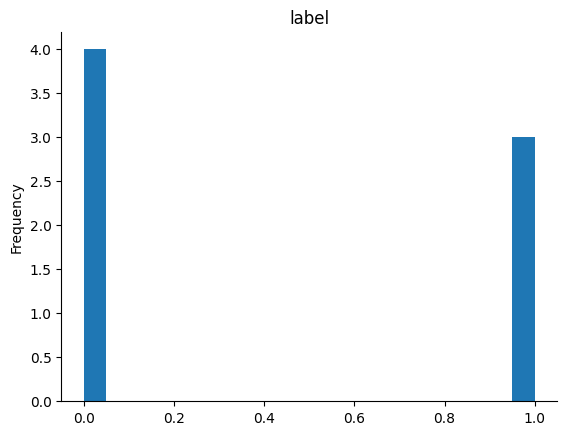

In [22]:
from matplotlib import pyplot as plt
txts_td['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
preds_txts = pipe(txts_td['text'].tolist())

In [16]:
preds_txts_df = pd.DataFrame(preds_txts)
preds_txts_df.rename(columns={'label':'pred'}, inplace=True)
preds_txts_df['pred'] = preds_txts_df['pred'].map({'LABEL_1': 1, 'LABEL_0': 0})

preds_txts_df = pd.concat([preds_txts_df, txts_td], axis=1)
preds_txts_df

,pred,score,label,text
0,1,0.744105,0,절대로 강추할 수 없는 영화
1,0,0.530384,0,절대로 추천할 수 없는 영화
2,1,0.972653,1,또 보고 싶다.
3,0,0.806542,0,이걸 보면서 웃을 수는 없다.
4,0,0.960768,0,처음에는 재미있었는데 갈수록 산으로 가는 내용.
5,1,0.969944,1,요즘 재미없는 영화만 나오는데 신선한 충격을 준 영화.
6,1,0.970179,1,유명한 감독이나 배우가 나오지는 않지만 스토리가 감동


In [20]:
# prompt: preds_txts_df DataFrame 사용: suggest a plot

import altair as alt
chart = alt.Chart(preds_txts_df).mark_bar().encode(
    x='pred:N',
    y='score:Q',
    color='pred:N',
    tooltip=['text:N', 'pred:N', 'score:Q', 'label:N']
).properties(height=400, width=600)
chart


/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)